check this 
https://github.com/auspatious/dea-coastlines/blob/5fb20451cf6cba151d656a8d213b1a5a04f16ad3/coastlines/combined.py#L105

In [7]:
# %% All the loads, farm input, datetime,

import os
import boto3
import rasterio as rio
from pystac_client import Client
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
from datetime import date, datetime

from stackstac import stack
import pystac
import rioxarray

from utils import *
import matplotlib.pyplot as plt

# Set environment and create AWS Session
os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'
os.environ['AWS_REQUEST_PAYER'] = 'requester'

print("Creating AWS Session")
aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)
print(aws_session)

# open Farm
run = 'ft0'
farm_file = '/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/CAR.gpkg'
folder_nc = farm_file.split('CAR.gpkg')[0] + f'nc/{run}/'
Path(folder_nc).mkdir( parents = True, exist_ok = True)
print(folder_nc)
farm = gpd.read_file(farm_file, layer='AREA_IMOVEL_1')
bbox = get_bbox(farm)

#  Satellite imagery query params
today = date.today()
datetime_range = str(f"2013-06-20/{str(today)}") #break  2017
max_cloud = 100
satellite = 'Landsat'

Creating AWS Session
/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/ft0/


In [8]:
# Usando todos Landsats
URL = 'https://landsatlook.usgs.gov/stac-server'
cat = Client.open(URL)
collection_id = 'landsat-c2l2-st' # thermal 'landsat-c2l2-st' optical 'landsat-c2l2-sr'
collection = cat.get_collection(collection_id)
print(collection)

query_params = {
        "eo:cloud_cover": {"lt": max_cloud},
        "platform": {"in": ["LANDSAT_5","LANDSAT_7","LANDSAT_8", "LANDSAT_9"]},
       "landsat:collection_category": { "in": ['T1']}
        }

<CollectionClient id=landsat-c2l2-st>


### the search and items

In [9]:
search = cat.search(
    collections = [collection_id],
    bbox = bbox,
    datetime = datetime_range,
    query = query_params,
)
print(f"{search.matched()} items found \n ---")
# prepare items collection
items_dict = search.item_collection_as_dict()['features']


491 items found 
 ---


In [10]:
items = search.item_collection()
items[0]


<Item id=LC09_L2SP_219075_20240502_20240503_02_T1_ST>

In [11]:
 # update URLs to use s3
for item in items_dict:
    for a in item['assets']:
        if 'alternate' in item['assets'][a] and 's3' in item['assets'][a]['alternate']:
            item['assets'][a]['href'] = item['assets'][a]['alternate']['s3']['href']
        item['assets'][a]['href'] = item['assets'][a]['href'].replace('usgs-landsat-ard', 'usgs-landsat')

item_collection = pystac.ItemCollection(items_dict)

# LOAD
with rio.Env(session = aws_session, AWS_S3_ENDPOINT= 's3.us-west-2.amazonaws.com'):
    dc = stack(item_collection,
                    #assets= assets,
                    chunksize = 256,
                    bounds_latlon = bbox,
                    epsg = 4326,
                    rescale=False, 
                    fill_value=0, 
                    dtype="uint16",
                    )
    


/home/mariano/geo/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


uns 5:30 pra carregar ate dar o erro `infer_datetime...`


In [ ]:
ds_ = dc.to_dataset( dim = 'band' ).persist()


### Trip moment on cloud_mask stuff from DEA

In [12]:
# # WORKING PROJECT DEA
# # https://github.com/auspatious/dea-coastlines/blob/5fb20451cf6cba151d656a8d213b1a5a04f16ad3/coastlines/combined.py#L212
# nodata_mask = (ds['T'] == 0) 
# mask_bitfields = [3, 4]  # cloud, cloud shadow
# bitmask = 0
# for field in mask_bitfields:
#     bitmask |= 1 << field

# cloud_mask = ds["qa_pixel"].astype(int) & bitmask != 0

# from odc.algo import mask_cleanup
# dilated_cloud_mask = mask_cleanup(cloud_mask, [("opening", 5), ("dilation", 6)])

# cloud_mask.plot(col='time', col_wrap = 8)

In [13]:
#ds['T'].plot(col='time', col_wrap = 8)

### WORK On LAND SURFACE TEMPERATURE

##### the original LWIRs

In [14]:
ds = ds_.copy()

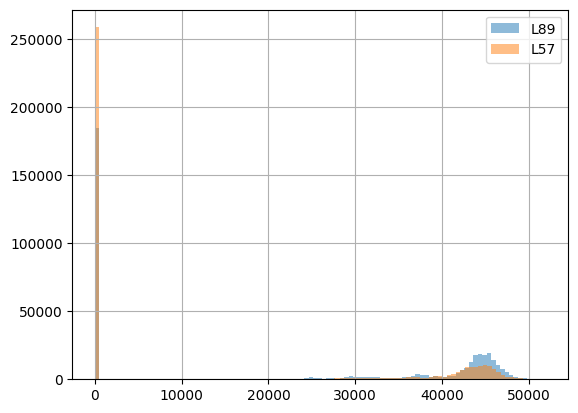

In [15]:
plt.hist(np.ravel(ds['lwir11'].values),bins=100, alpha=0.5, label='L89');
plt.hist(np.ravel(ds['lwir'].values),bins=100, alpha=0.5, label='L57');
plt.legend();plt.grid()

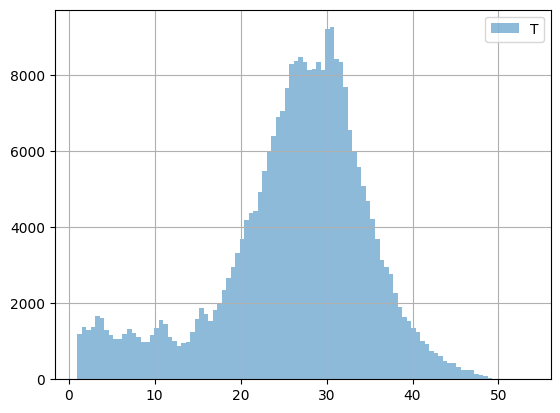

In [16]:
# SOMA, to Celcius and put nans
ds['T'] = (ds['lwir'] + ds['lwir11']) * 0.00341802 + 149 - 273.15

ds['T'] = ds['T'].astype('float32')
ds['T'] = xr.where(ds['T'] < 1, np.nan , ds['T'])

plt.hist(np.ravel(ds['T'].values),bins=100, alpha=0.5, label='T');
plt.legend();plt.grid()

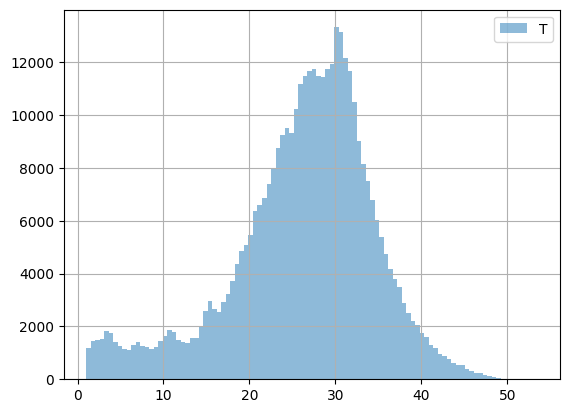

In [17]:
ds['T'] = ds['T'].chunk(dict(time=-1))
ds['T'] = ds['T'].interpolate_na(dim="time",
                method='linear',
                use_coordinate=True, 
            ) 

plt.hist(np.ravel(ds['T'].values),bins=100, alpha=0.5, label='T');
plt.legend();plt.grid()

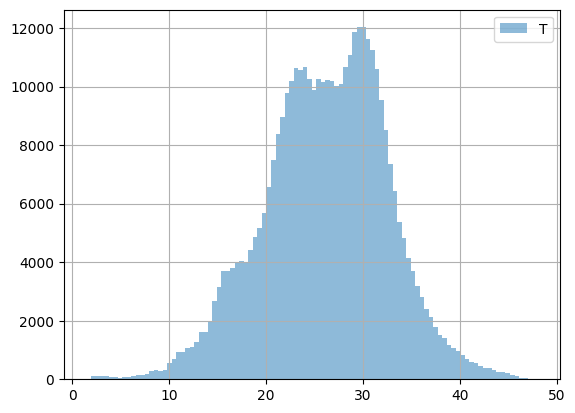

In [18]:
# rolling
w = 3
ds['T'] = ds['T'].rolling(time=w, center=True).mean(skipna=True)

plt.hist(np.ravel(ds['T'].values),bins=100, alpha=0.5, label='T');
plt.legend();plt.grid()

##### PREP 2 GO
com os cortes, interpolate_na e um leve smoothing, já tem cara de dado

In [19]:
ds2go = dropper(ds['T'], 'Landsat')
# REPROJECTION
print(f'\n reprojecting cube for {datetime_range}')
ds2go = ds2go.rio.write_crs('epsg:4326')
ds2go = ds2go.rio.reproject('EPSG:4326')
ds2go = ds2go.rename({'x': 'longitude','y': 'latitude'})
print('reprojecting... done')

# t0 = str(ds2go.time[0].values).split('T')[0]
# t1 = str(ds2go.time[-1].values).split('T')[0]
# n = len(ds2go.time)

# ds2go.to_netcdf('/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/LST_{t0}-{t1}_{n}.nc')

<<< landsat:correction dropped
<<< landsat:wrs_path dropped
<<< landsat:wrs_row dropped
<<< landsat:cloud_cover_land dropped
<<< landsat:collection_number dropped
<<< landsat:wrs_type dropped
<<< instruments dropped
--- raster:bands was not here
<<< eo:cloud_cover dropped
<<< accuracy:geometric_x_stddev dropped
no attribute spec to remove

 reprojecting cube for 2013-06-20/2024-05-09
reprojecting... done


In [22]:
t_m = ds2go.resample(time = 'ME').mean(skipna=True)

In [26]:
t0 = str(t_m.time[0].values).split('T')[0]
t1 = str(t_m.time[-1].values).split('T')[0]
n = len(t_m.time)

t_m.to_netcdf(f'/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/LST_{t0}-{t1}_{n}.nc')